# Modelo de Clustering

=== MODELO DE CLUSTERING MODIFICADO ===
Análisis de Patrones Nutricionales en Recetas

1. CARGA Y EXPLORACIÓN DE DATOS
----------------------------------------

--- Información del Dataset ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 947 entries, 0 to 946
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   recipe        947 non-null    int64  
 1   calories      895 non-null    float64
 2   carbohydrate  895 non-null    float64
 3   sugar         895 non-null    float64
 4   protein       895 non-null    float64
 5   category      947 non-null    object 
 6   servings      947 non-null    object 
 7   high_traffic  574 non-null    object 
dtypes: float64(4), int64(1), object(3)
memory usage: 59.3+ KB
None

--- Primeras 5 filas ---
   recipe  calories  carbohydrate  sugar  protein   category servings  \
0       1       NaN           NaN    NaN      NaN       Pork        6   
1       2     35.48         38.56

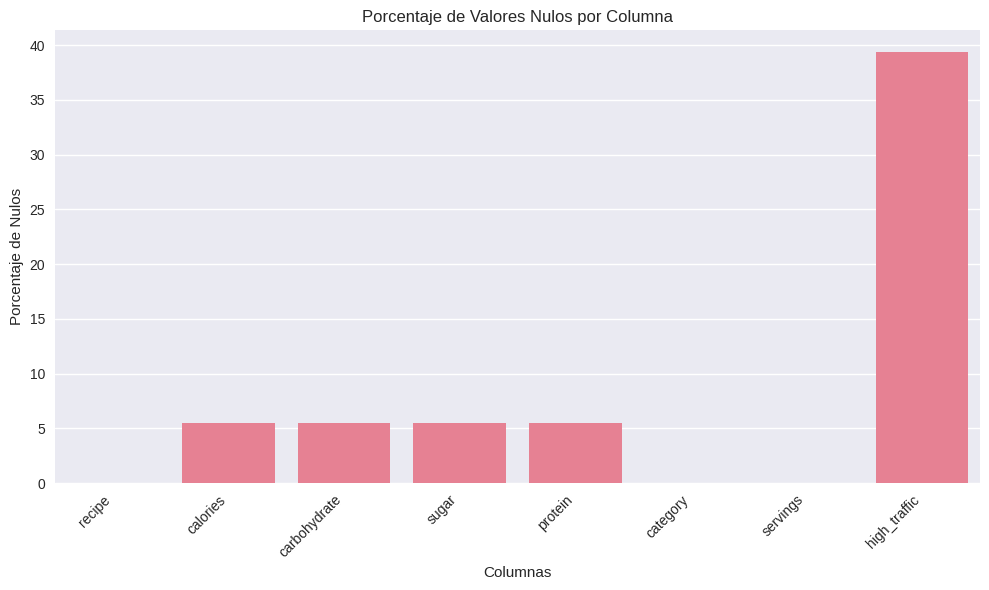

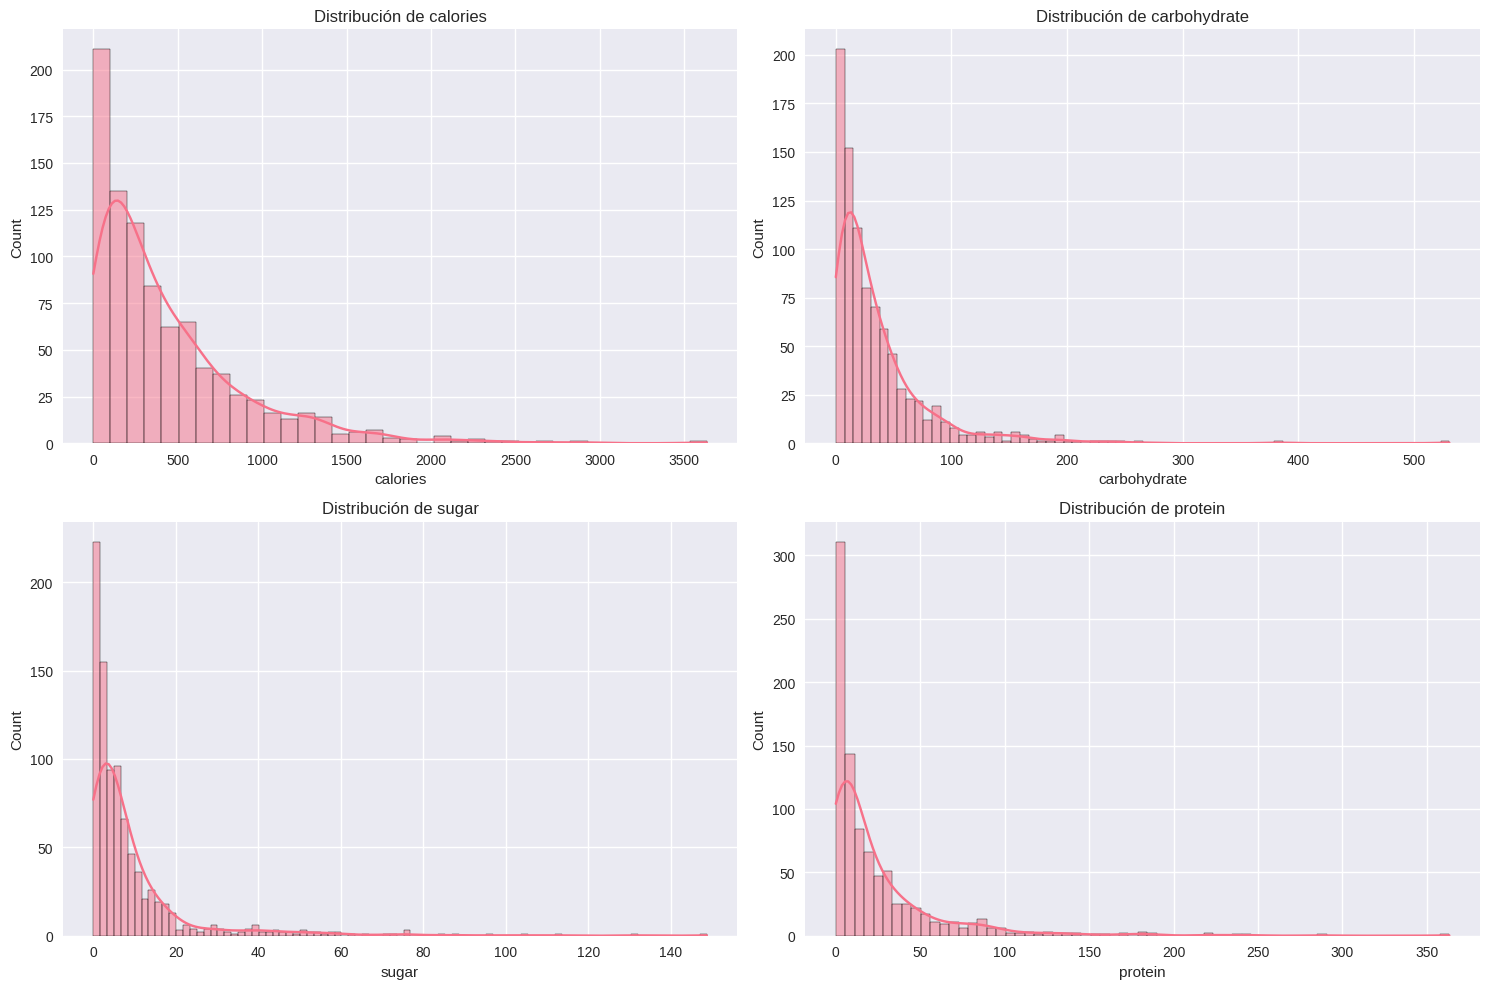

In [1]:

!pip install pandas numpy matplotlib seaborn scikit-learn


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN, SpectralClustering
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.neighbors import NearestNeighbors
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.manifold import TSNE
import warnings
warnings.filterwarnings('ignore')


plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("=== MODELO DE CLUSTERING MODIFICADO ===")
print("Análisis de Patrones Nutricionales en Recetas")
print("=" * 50)


print("\n1. CARGA Y EXPLORACIÓN DE DATOS")
print("-" * 40)


df = pd.read_csv('recipe_site_traffic_2212.csv')



print("\n--- Información del Dataset ---")
print(df.info())

print("\n--- Primeras 5 filas ---")
print(df.head())

print("\n--- Estadísticas descriptivas ---")
print(df.describe())


print("\n--- Análisis de Valores Nulos ---")
null_counts = df.isnull().sum()
null_percentages = (df.isnull().sum() / len(df)) * 100
null_analysis = pd.DataFrame({
    "Valores_Nulos": null_counts,
    "Porcentaje": null_percentages
})
print(null_analysis)

numeric_columns = ["calories", "carbohydrate", "sugar", "protein"]

plt.figure(figsize=(10, 6))
sns.barplot(x=null_analysis.index, y="Porcentaje", data=null_analysis)
plt.title("Porcentaje de Valores Nulos por Columna")
plt.ylabel("Porcentaje de Nulos")
plt.xlabel("Columnas")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

plt.figure(figsize=(15, 10))
for i, col in enumerate(numeric_columns):
    plt.subplot(2, 2, i + 1)
    sns.histplot(df[col].dropna(), kde=True)
    plt.title(f"Distribución de {col}")
plt.tight_layout()
plt.show()


# Preprocesamiento de Datos

In [2]:

numeric_columns = ["calories", "carbohydrate", "sugar", "protein"]
print(f"Columnas numéricas seleccionadas: {numeric_columns}")


df_clean = df[numeric_columns].dropna()
print(f"Filas después de eliminar nulos: {len(df_clean)}")


df_transformed = df_clean.copy()
for col in numeric_columns:
    df_transformed[col] = np.log1p(df_transformed[col])

print("\n--- Datos transformados (log1p) ---")
print(df_transformed.describe())


Columnas numéricas seleccionadas: ['calories', 'carbohydrate', 'sugar', 'protein']
Filas después de eliminar nulos: 895

--- Datos transformados (log1p) ---
         calories  carbohydrate       sugar     protein
count  895.000000    895.000000  895.000000  895.000000
mean     5.466465      3.006121    1.752263    2.428831
std      1.307362      1.146348    0.988886    1.323778
min      0.131028      0.029559    0.009950    0.000000
25%      4.713394      2.238029    0.989541    1.433887
50%      5.668328      3.112626    1.713798    2.468100
75%      6.394677      3.827877    2.379546    3.440378
max      8.198133      6.275553    5.008967    5.898142



# Escalado de Datos

In [3]:

scaler = RobustScaler()
X_scaled = scaler.fit_transform(df_transformed)
print(f"Datos escalados con forma {X_scaled.shape}")
print(f"\nUsando RobustScaler para el análisis principal")


Datos escalados con forma (895, 4)

Usando RobustScaler para el análisis principal


# Análisis de Componentes Principales

Varianza explicada por componente:
PC1: 0.325 (32.5%)
PC2: 0.254 (25.4%)
PC3: 0.239 (23.9%)
PC4: 0.182 (18.2%)

Varianza acumulada:
PC1-PC1: 0.325 (32.5%)
PC1-PC2: 0.579 (57.9%)
PC1-PC3: 0.818 (81.8%)
PC1-PC4: 1.000 (100.0%)


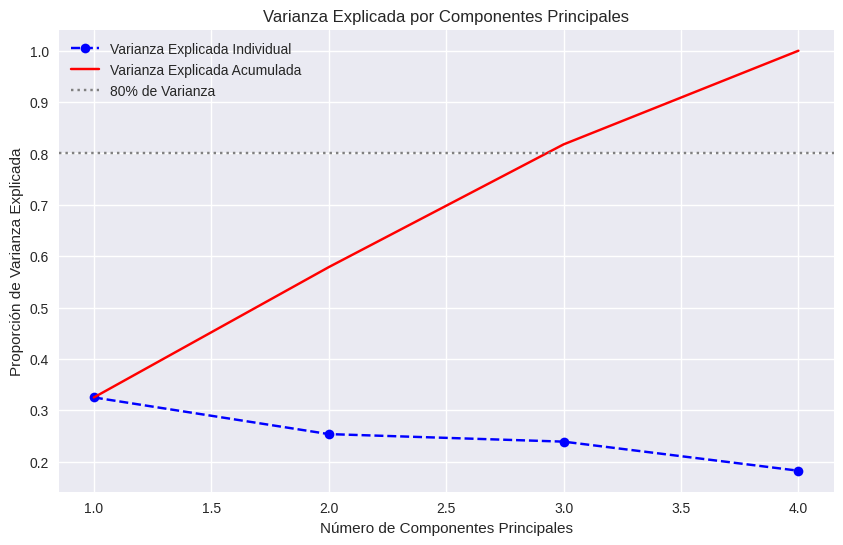


Componentes necesarios para 80% de varianza: 3


In [4]:

pca = PCA()
X_pca = pca.fit_transform(X_scaled)


explained_variance = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance)

print("Varianza explicada por componente:")
for i, var in enumerate(explained_variance):
    print(f"PC{i+1}: {var:.3f} ({var*100:.1f}%)")

print(f"\nVarianza acumulada:")
for i, cum_var in enumerate(cumulative_variance):
    print(f"PC1-PC{i+1}: {cum_var:.3f} ({cum_var*100:.1f}%)")


plt.figure(figsize=(10, 6))
plt.plot(range(1, len(explained_variance) + 1), explained_variance, marker="o", linestyle="--", color="blue", label="Varianza Explicada Individual")
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker="x", linestyle="-", color="red", label="Varianza Explicada Acumulada")
plt.title("Varianza Explicada por Componentes Principales")
plt.xlabel("Número de Componentes Principales")
plt.ylabel("Proporción de Varianza Explicada")
plt.axhline(y=0.8, color="gray", linestyle=":", label="80% de Varianza")
plt.legend()
plt.grid(True)
plt.show()


n_components_80 = np.argmax(cumulative_variance >= 0.8) + 1
print(f"\nComponentes necesarios para 80% de varianza: {n_components_80}")


# Determinación del Número Óptimo de Clusters

Evaluando diferentes números de clusters...
k=2: Silhouette=0.214, Calinski-Harabasz=239.2, Davies-Bouldin=1.791
k=3: Silhouette=0.187, Calinski-Harabasz=220.6, Davies-Bouldin=1.591
k=4: Silhouette=0.200, Calinski-Harabasz=222.9, Davies-Bouldin=1.442
k=5: Silhouette=0.202, Calinski-Harabasz=213.9, Davies-Bouldin=1.334
k=6: Silhouette=0.183, Calinski-Harabasz=199.8, Davies-Bouldin=1.400
k=7: Silhouette=0.190, Calinski-Harabasz=191.1, Davies-Bouldin=1.343
k=8: Silhouette=0.187, Calinski-Harabasz=183.8, Davies-Bouldin=1.335
k=9: Silhouette=0.187, Calinski-Harabasz=179.2, Davies-Bouldin=1.310
k=10: Silhouette=0.183, Calinski-Harabasz=171.7, Davies-Bouldin=1.323


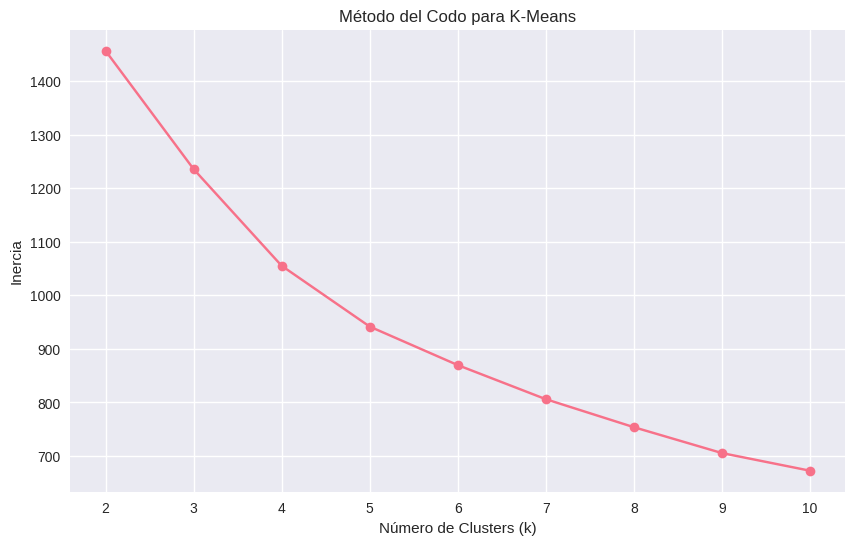

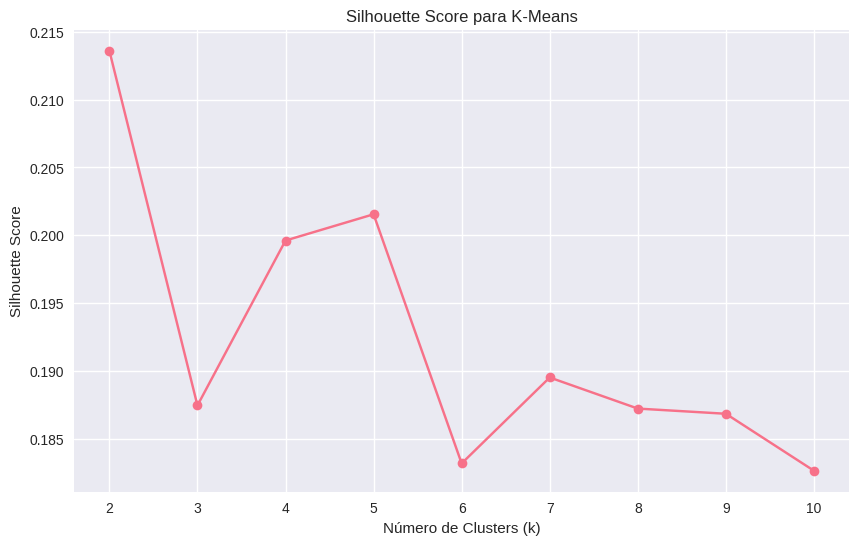


Número óptimo de clusters (Silhouette): 2


In [5]:

k_range = range(2, 11)
inertias = []
silhouette_scores = []
calinski_scores = []
davies_bouldin_scores = []

print("Evaluando diferentes números de clusters...")
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    cluster_labels = kmeans.fit_predict(X_scaled)

    inertias.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X_scaled, cluster_labels))
    calinski_scores.append(calinski_harabasz_score(X_scaled, cluster_labels))
    davies_bouldin_scores.append(davies_bouldin_score(X_scaled, cluster_labels))

    print(f"k={k}: Silhouette={silhouette_scores[-1]:.3f}, "
          f"Calinski-Harabasz={calinski_scores[-1]:.1f}, "
          f"Davies-Bouldin={davies_bouldin_scores[-1]:.3f}")


plt.figure(figsize=(10, 6))
plt.plot(k_range, inertias, marker="o")
plt.title("Método del Codo para K-Means")
plt.xlabel("Número de Clusters (k)")
plt.ylabel("Inercia")
plt.xticks(k_range)
plt.grid(True)
plt.show()


plt.figure(figsize=(10, 6))
plt.plot(k_range, silhouette_scores, marker="o")
plt.title("Silhouette Score para K-Means")
plt.xlabel("Número de Clusters (k)")
plt.ylabel("Silhouette Score")
plt.xticks(k_range)
plt.grid(True)
plt.show()


optimal_k = k_range[np.argmax(silhouette_scores)]
print(f"\nNúmero óptimo de clusters (Silhouette): {optimal_k}")


# Aplicación de Algoritmos de Clustering

Aplicando K-Means...
Aplicando Clustering Jerárquico...
Aplicando DBSCAN...


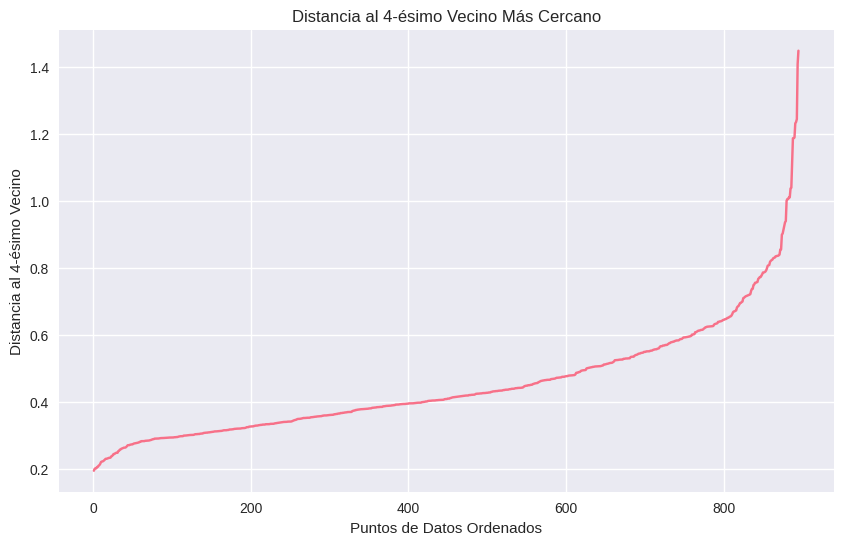

DBSCAN encontró 1 clusters
Aplicando Spectral Clustering...


In [6]:

clustering_results = {}


print("Aplicando K-Means...")
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
kmeans_labels = kmeans.fit_predict(X_scaled)
clustering_results["K-Means"] = {
    "labels": kmeans_labels,
    "silhouette": silhouette_score(X_scaled, kmeans_labels),
    "calinski": calinski_harabasz_score(X_scaled, kmeans_labels),
    "davies_bouldin": davies_bouldin_score(X_scaled, kmeans_labels)
}


print("Aplicando Clustering Jerárquico...")
agg_clustering = AgglomerativeClustering(n_clusters=optimal_k, linkage="ward")
agg_labels = agg_clustering.fit_predict(X_scaled)
clustering_results["Jerárquico"] = {
    "labels": agg_labels,
    "silhouette": silhouette_score(X_scaled, agg_labels),
    "calinski": calinski_harabasz_score(X_scaled, agg_labels),
    "davies_bouldin": davies_bouldin_score(X_scaled, agg_labels)
}


print("Aplicando DBSCAN...")
k_neighbors = 4
neighbors = NearestNeighbors(n_neighbors=k_neighbors)
neighbors_fit = neighbors.fit(X_scaled)
distances, indices = neighbors_fit.kneighbors(X_scaled)
distances = np.sort(distances[:, k_neighbors-1], axis=0)

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(distances) + 1), distances)
plt.title(f"Distancia al {k_neighbors}-ésimo Vecino Más Cercano")
plt.xlabel("Puntos de Datos Ordenados")
plt.ylabel(f"Distancia al {k_neighbors}-ésimo Vecino")
plt.grid(True)
plt.show()

eps = np.percentile(distances, 90)

dbscan = DBSCAN(eps=eps, min_samples=k_neighbors)
dbscan_labels = dbscan.fit_predict(X_scaled)

if len(set(dbscan_labels)) > 1:
    clustering_results["DBSCAN"] = {
        "labels": dbscan_labels,
        "silhouette": silhouette_score(X_scaled, dbscan_labels),
        "calinski": calinski_harabasz_score(X_scaled, dbscan_labels),
        "davies_bouldin": davies_bouldin_score(X_scaled, dbscan_labels)
    }
    print(f"DBSCAN encontró {len(set(dbscan_labels)) - (1 if -1 in dbscan_labels else 0)} clusters")
else:
    print("DBSCAN no encontró clusters válidos")


print("Aplicando Spectral Clustering...")
spectral = SpectralClustering(n_clusters=optimal_k, random_state=42)
spectral_labels = spectral.fit_predict(X_scaled)
clustering_results["Spectral"] = {
    "labels": spectral_labels,
    "silhouette": silhouette_score(X_scaled, spectral_labels),
    "calinski": calinski_harabasz_score(X_scaled, spectral_labels),
    "davies_bouldin": davies_bouldin_score(X_scaled, spectral_labels)
}


# Comparación y Selección del Mejor Algoritmo

In [7]:
print(f"{'Algoritmo':<15} {'Silhouette':<12} {'Calinski-H':<12} {'Davies-B':<10}")
print("-" * 50)

for name, results in clustering_results.items():
    print(f"{name:<15} {results['silhouette'] :<12.3f} {results['calinski'] :<12.1f} {results['davies_bouldin'] :<10.3f}")

best_algorithm = max(clustering_results.keys(),
                    key=lambda x: clustering_results[x]["silhouette"])
best_labels = clustering_results[best_algorithm]["labels"]

print(f"\nMejor algoritmo: {best_algorithm}")
print(f"Silhouette Score: {clustering_results[best_algorithm]['silhouette']:.3f}")


Algoritmo       Silhouette   Calinski-H   Davies-B  
--------------------------------------------------
K-Means         0.214        239.2        1.791     
Jerárquico      0.172        193.7        2.002     
DBSCAN          0.321        42.2         2.330     
Spectral        0.248        214.8        1.727     

Mejor algoritmo: DBSCAN
Silhouette Score: 0.321


# Análisis e Interpretación de Clusters

In [9]:
df_analysis = df_clean.copy()
df_analysis["Cluster"] = best_labels

print("Estadísticas por cluster:")
cluster_stats = df_analysis.groupby("Cluster").agg({
    "calories": ["mean", "std", "count"],
    "carbohydrate": ["mean", "std"],
    "sugar": ["mean", "std"],
    "protein": ["mean", "std"]
}).round(2)

print(cluster_stats)

print("\n--- Interpretación de Clusters ---")
for cluster_id in sorted(df_analysis["Cluster"].unique()):
    cluster_data = df_analysis[df_analysis["Cluster"] == cluster_id]
    n_recipes = len(cluster_data)

    print(f"\nCluster {cluster_id} ({n_recipes} recetas):")
    print(f"  - Calorías promedio: {cluster_data['calories'].mean():.1f}")
    print(f"  - Carbohidratos promedio: {cluster_data['carbohydrate'].mean():.1f}g")
    print(f"  - Azúcar promedio: {cluster_data['sugar'].mean():.1f}g")
    print(f"  - Proteína promedio: {cluster_data['protein'].mean():.1f}g")

    if cluster_data["calories"].mean() > df_clean["calories"].mean():
        cal_level = "Alto"
    else:
        cal_level = "Bajo"

    if cluster_data["protein"].mean() > df_clean["protein"].mean():
        protein_level = "Alto"
    else:
        protein_level = "Bajo"

    print(f"  - Característica: {cal_level} en calorías, {protein_level} en proteínas")

Estadísticas por cluster:
        calories               carbohydrate          sugar        protein  \
            mean     std count         mean     std   mean    std    mean   
Cluster                                                                     
-1        239.47  621.36    43        60.88  103.26  27.01  32.99   16.74   
 0        445.85  441.01   852        33.77   38.31   8.14  12.47   24.52   

                
           std  
Cluster         
-1       23.90  
 0       36.86  

--- Interpretación de Clusters ---

Cluster -1 (43 recetas):
  - Calorías promedio: 239.5
  - Carbohidratos promedio: 60.9g
  - Azúcar promedio: 27.0g
  - Proteína promedio: 16.7g
  - Característica: Bajo en calorías, Bajo en proteínas

Cluster 0 (852 recetas):
  - Calorías promedio: 445.9
  - Carbohidratos promedio: 33.8g
  - Azúcar promedio: 8.1g
  - Proteína promedio: 24.5g
  - Característica: Alto en calorías, Alto en proteínas


# Visualización con t-SNE

Aplicando t-SNE para visualización...
t-SNE completado. Datos listos para visualización.


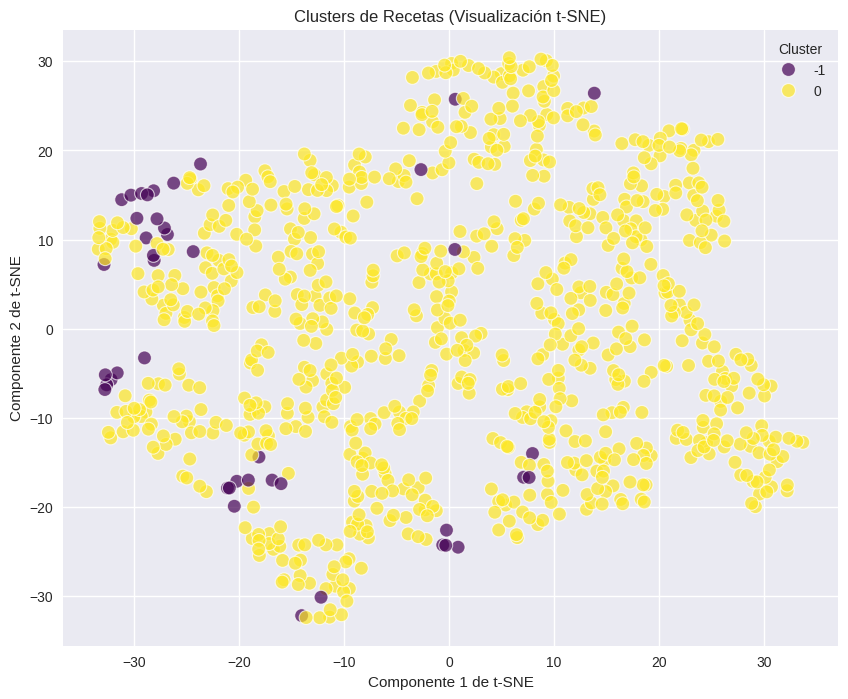

In [10]:
print("Aplicando t-SNE para visualización...")
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
X_tsne = tsne.fit_transform(X_scaled)

print("t-SNE completado. Datos listos para visualización.")


plt.figure(figsize=(10, 8))
sns.scatterplot(x=X_tsne[:, 0], y=X_tsne[:, 1], hue=best_labels, palette="viridis", s=100, alpha=0.7)
plt.title("Clusters de Recetas (Visualización t-SNE)")
plt.xlabel("Componente 1 de t-SNE")
plt.ylabel("Componente 2 de t-SNE")
plt.legend(title="Cluster")
plt.grid(True)
plt.show()


In [12]:
print("\n\n10. RESUMEN FINAL")
print("-" * 40)

print(f"Dataset original: {df.shape[0]} recetas")
print(f"Dataset limpio: {len(df_clean)} recetas")
print(f"Algoritmo seleccionado: {best_algorithm}")
print(f"Número de clusters: {len(set(best_labels))}")
print(f"Silhouette Score: {clustering_results[best_algorithm]['silhouette']:.3f}")

print("\nCaracterísticas de los clusters encontrados:")
for cluster_id in sorted(df_analysis["Cluster"].unique()):
    cluster_data = df_analysis[df_analysis["Cluster"] == cluster_id]
    n_recipes = len(cluster_data)
    percentage = (n_recipes / len(df_analysis)) * 100
    print(f"  - Cluster {cluster_id}: {n_recipes} recetas ({percentage:.1f}%)")

print("\nANÁLISIS COMPLETADO ")




10. RESUMEN FINAL
----------------------------------------
Dataset original: 947 recetas
Dataset limpio: 895 recetas
Algoritmo seleccionado: DBSCAN
Número de clusters: 2
Silhouette Score: 0.321

Características de los clusters encontrados:
  - Cluster -1: 43 recetas (4.8%)
  - Cluster 0: 852 recetas (95.2%)

ANÁLISIS COMPLETADO 
